### Outlier Factors for Device Profiling

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

df = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=20000)

df.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

#df = pd.read_csv('../../../diploma/generated_data/500_400000(non_uniform)_1-200_True_C4_7.txt', header=None)

#df.columns = ['time', 'source computer', 'byte count']

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# or try a simple generated dataset
len(df)

20000

In [3]:
from sklearn.preprocessing import MinMaxScaler

def scale(x):
    return np.log(x + 1)
   

class customScaler():
    def __init__(self, feature_range=(1,100)):
        self.feature_range = feature_range
    
    def fit(self, x):
        scaled_data = scale(x)
        self.scaler = MinMaxScaler(feature_range=self.feature_range)
        self.scaler.fit(scaled_data)

    def transform(self, data):
        scaled_data = scale(data)
        transformed = self.scaler.transform(scaled_data).astype(int)
        return np.array(transformed, dtype=np.int64)

In [4]:
from helper import group_data

scaler = customScaler()

groupped_data, hosts = group_data(df, size_of_bin_seconds=50, doScale=True, scaler=scaler)

In [5]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories

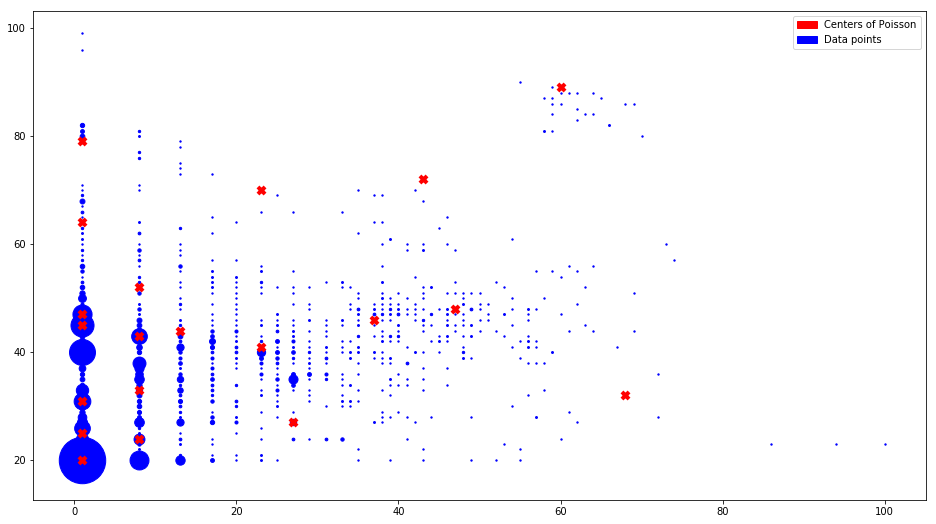

In [6]:
from helper import get_random_initialize_lamdas
from kplusplus import KPlusPlus

mixtures = 20

kplusplus = KPlusPlus(mixtures, groupped_data.values[:,:-1])

kplusplus.init_centers()

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, verbose=1)
plot_points(groupped_data.values[:,:-1], onlineEM)

In [7]:
onlineEM.fit(groupped_data.values)

Running for data till position 500 from total 5381
Running for data till position 1000 from total 5381
Running for data till position 1500 from total 5381
Running for data till position 2000 from total 5381
Running for data till position 2500 from total 5381
Running for data till position 3000 from total 5381
Running for data till position 3500 from total 5381
Running for data till position 4000 from total 5381
Running for data till position 4500 from total 5381
Running for data till position 5000 from total 5381
Running for data till position 5381 from total 5381
Running clustering algorithm


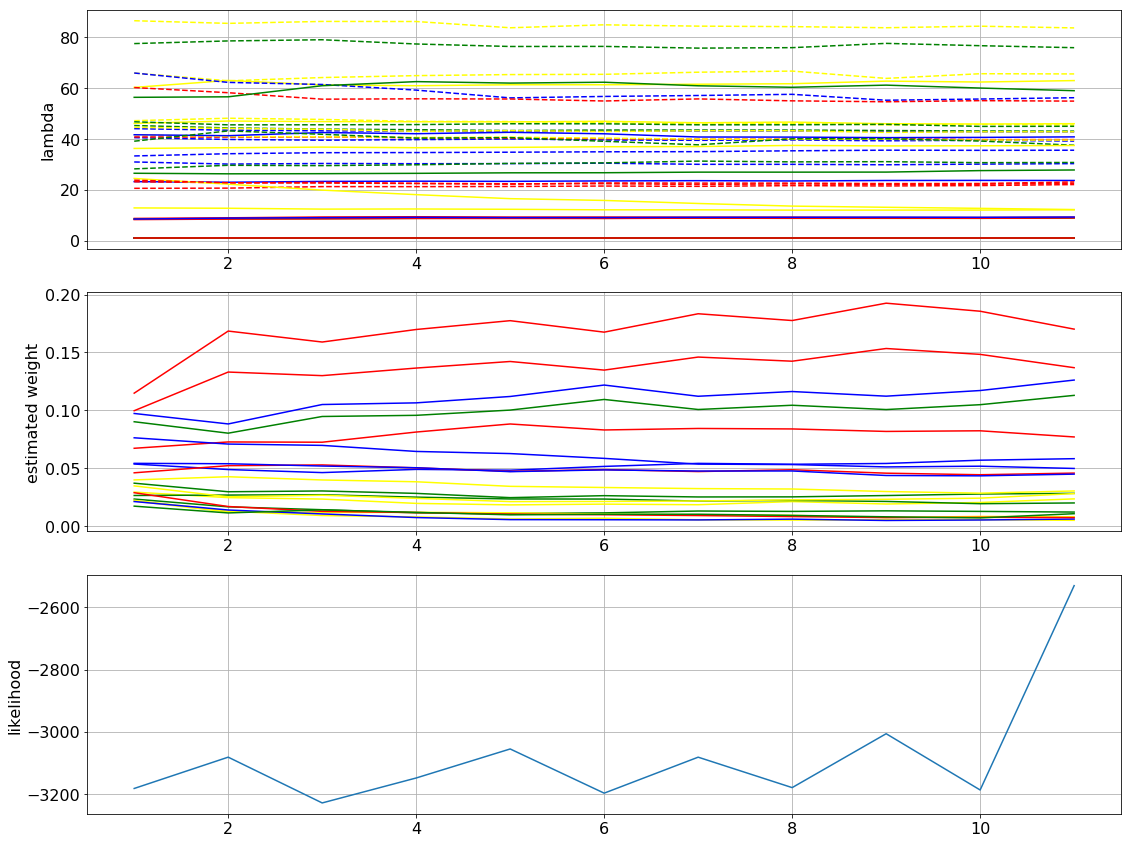

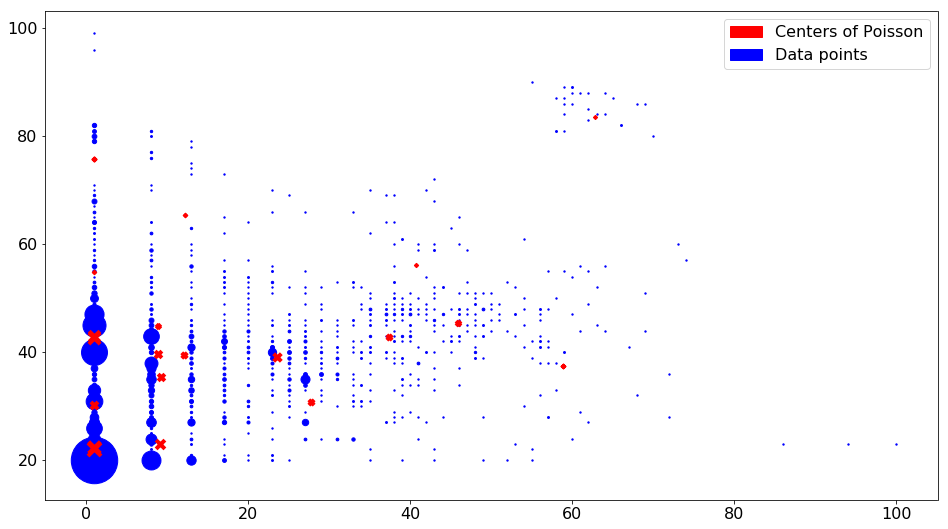

In [8]:
plot_results(onlineEM, legend=False)
plot_points(groupped_data.values[:,:-1], onlineEM)

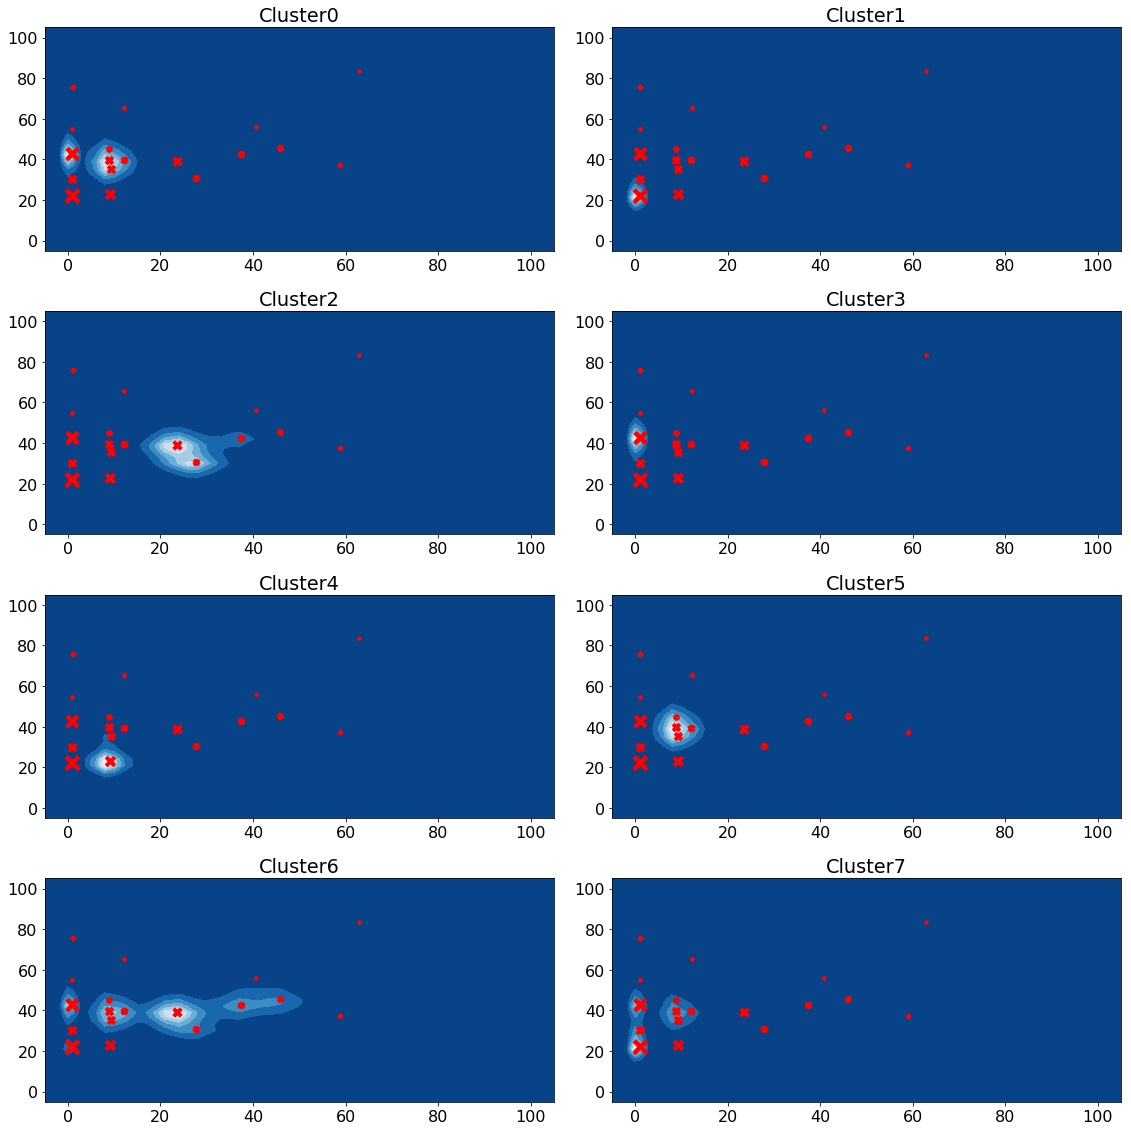

In [9]:
plot_all_categories(onlineEM)

#### Here are the anomalies from this data set and by host 

In [10]:
r = onlineEM.score_anomaly(groupped_data.values)

In [11]:
flags = r < onlineEM.threshold
print('A total of', np.sum(flags), 'anomalies')

# print(groupped_data.values[flags])
anomalies = groupped_data.values[flags]

import numpy_indexed as npi
anomalies_indexed = npi.group_by(anomalies[:, 2])

A total of 15 anomalies


In [12]:
anomalies_per_host = np.column_stack((anomalies_indexed.unique, anomalies_indexed.count.T))
anomalies_per_host = anomalies_per_host[anomalies_per_host[:,1].argsort()][::-1]
print('A total of', len(anomalies_per_host), 'users have been found to have anomalous behavior')

A total of 11 users have been found to have anomalous behavior


In [13]:
anomalies_per_host[:10]

array([['C16712', 3],
       ['C5721', 2],
       ['C17926', 2],
       ['C625', 1],
       ['C5788', 1],
       ['C3083', 1],
       ['C22112', 1],
       ['C2026', 1],
       ['C16054', 1],
       ['C1295', 1]], dtype=object)

See for a particular host what is going on 

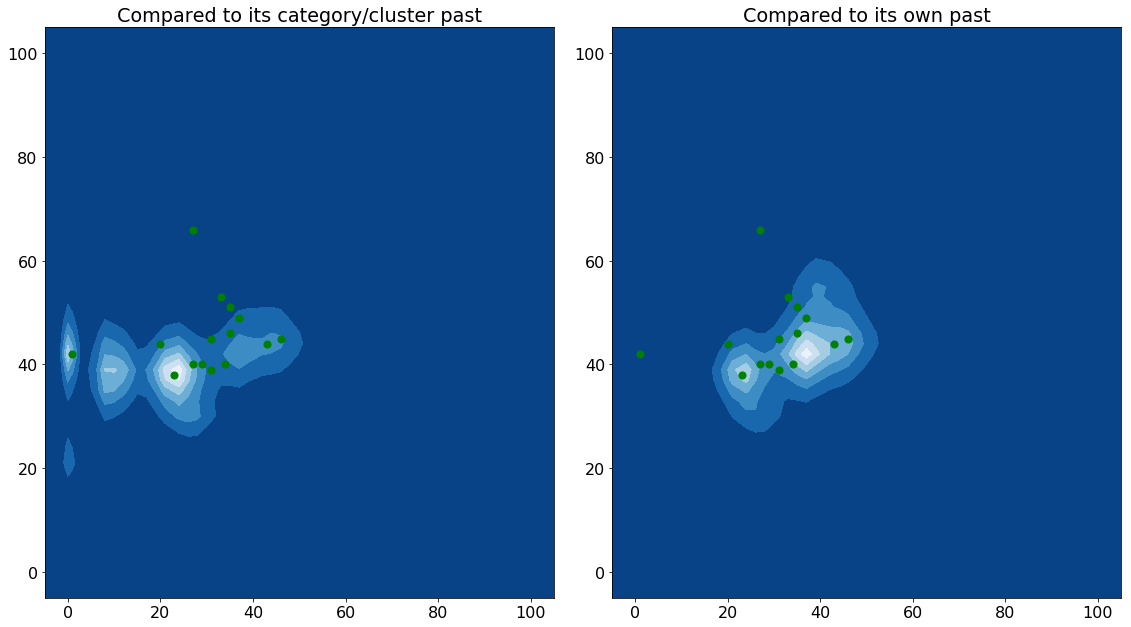

In [21]:
from plots import plot_for_host

data_for_host = plot_for_host('C625', onlineEM, groupped_data.values)
# print(data_for_host)

In [22]:
data_for_host[:10]

[(array([27, 66, 'C625'], dtype=object), 9.014500843976367e-05),
 (array([33, 53, 'C625'], dtype=object), 0.0066706951191373423),
 (array([35, 51, 'C625'], dtype=object), 0.012750225055663245),
 (array([20, 44, 'C625'], dtype=object), 0.014771864780355061),
 (array([31, 45, 'C625'], dtype=object), 0.015407525469485685),
 (array([1, 42, 'C625'], dtype=object), 0.017180095609407777),
 (array([31, 39, 'C625'], dtype=object), 0.020284150738890859),
 (array([29, 40, 'C625'], dtype=object), 0.021938974561890125),
 (array([37, 49, 'C625'], dtype=object), 0.022543174715140949),
 (array([35, 46, 'C625'], dtype=object), 0.027429821849322029)]

In [29]:
test = []

for point in groupped_data.values:
    tt = onlineEM.score_anomaly_for_category(point[0:2])
    if (tt < 0.000001):
        test.append((point, tt))
print(len(test))        

74


In [30]:
test

[(array([23, 65, 'C625'], dtype=object), 6.5716283296916768e-07),
 (array([21, 68, 'C1295'], dtype=object), 1.3905576289224262e-07),
 (array([83, 23, 'C16712'], dtype=object), 3.5276339562503579e-08),
 (array([36, 71, 'C5721'], dtype=object), 4.3432778161682686e-07),
 (array([72, 23, 'C16712'], dtype=object), 6.5250958190744707e-07),
 (array([19, 69, 'C20101'], dtype=object), 6.8604139198330126e-07),
 (array([61, 59, 'C5721'], dtype=object), 9.5387263666479583e-08),
 (array([31, 68, 'C5721'], dtype=object), 6.6615111713464351e-07),
 (array([78, 23, 'C16712'], dtype=object), 1.6100813413036019e-07),
 (array([19, 65, 'C11573'], dtype=object), 5.1782834299029549e-07),
 (array([30, 69, 'C5721'], dtype=object), 4.3559175454479985e-07),
 (array([62, 56, 'C5721'], dtype=object), 1.2831260401863159e-07),
 (array([32, 67, 'C5721'], dtype=object), 9.726070389148908e-07),
 (array([36, 67, 'C5721'], dtype=object), 7.9985460034651463e-07),
 (array([35, 69, 'C5721'], dtype=object), 3.526983228072211

In [86]:
onlineEM.lambdas[6]

array([50.66885286720838, 83.9036709944296], dtype=object)

In [34]:
onlineEM.gammas

array([ 0.01256461,  0.03963829,  0.01888782,  0.0722305 ,  0.29969088,
        0.00421236,  0.00419753,  0.00553522,  0.13471942,  0.05226218,
        0.00509684,  0.07546205,  0.02186469,  0.06168858,  0.05155586,
        0.04328016,  0.00677478,  0.00701427,  0.02684014,  0.05648382])

In [17]:
from sklearn.externals import joblib  
joblib.dump(onlineEM, 'onlineEM_???.pkl')

['onlineEM_2000000_20.pkl']

In [20]:
import somoclu

In [30]:
n_rows, n_columns = 15,15
som = somoclu.Somoclu(n_columns, n_rows)

%time som.train(groupped_data.values[:,:-1],epochs=100)

Wall time: 988 ms


In [31]:
bmus = som.bmus

unique_bmus = np.unique(bmus, axis=0)
movies_to_bmus = []
for i,j in unique_bmus:
    movies_to_bmus.append([idx for idx in range(len(bmus)) if (bmus[idx][0] == i and bmus[idx][1] == j)])

movies_to_bmus = np.array(movies_to_bmus)

In [32]:
from sklearn.cluster import KMeans

n_clusters = 25
som.cluster(algorithm=KMeans(n_clusters=n_clusters))

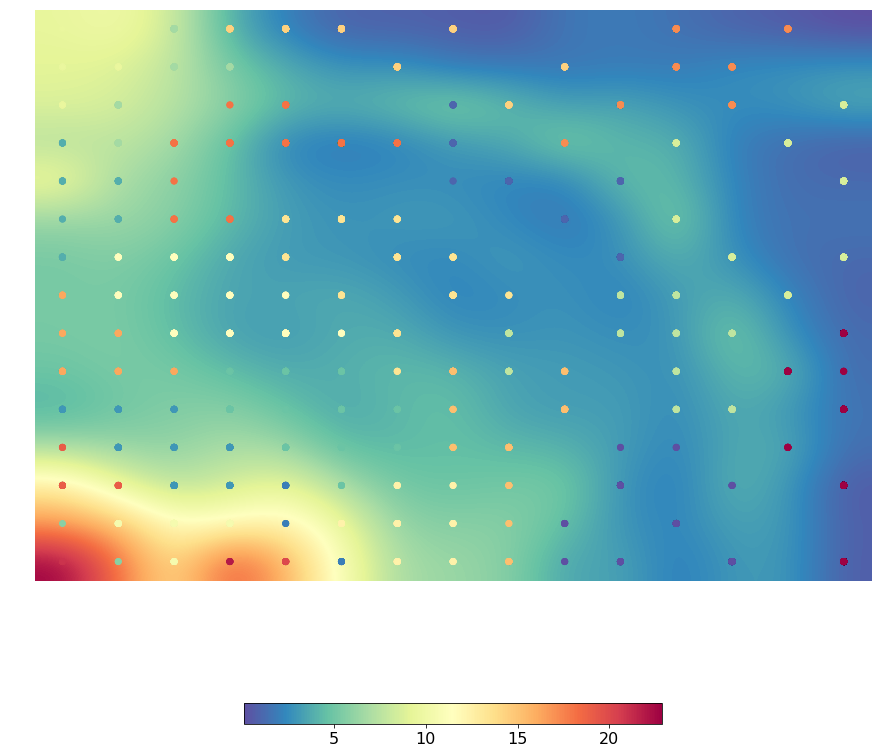

<module 'matplotlib.pyplot' from 'c:\\users\\sotiris\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [33]:
som.view_umatrix(figsize=(15, 15), bestmatches=True, colorbar=True)

### How to choose the correct number of categories

try the elbow method

see also gap statistic

In [11]:
from sklearn.cluster import KMeans

In [12]:
closest_centers = []

for host in onlineEM.hosts.keys():
    closest_centers.append(onlineEM.hosts[host]['group'])

In [13]:
cluster_sizes = range(3, 10)

cluster_scores = []

for k in cluster_sizes:
    km = KMeans(k, random_state=77)
    km.fit(closest_centers)
    cluster_scores.append(km.inertia_)

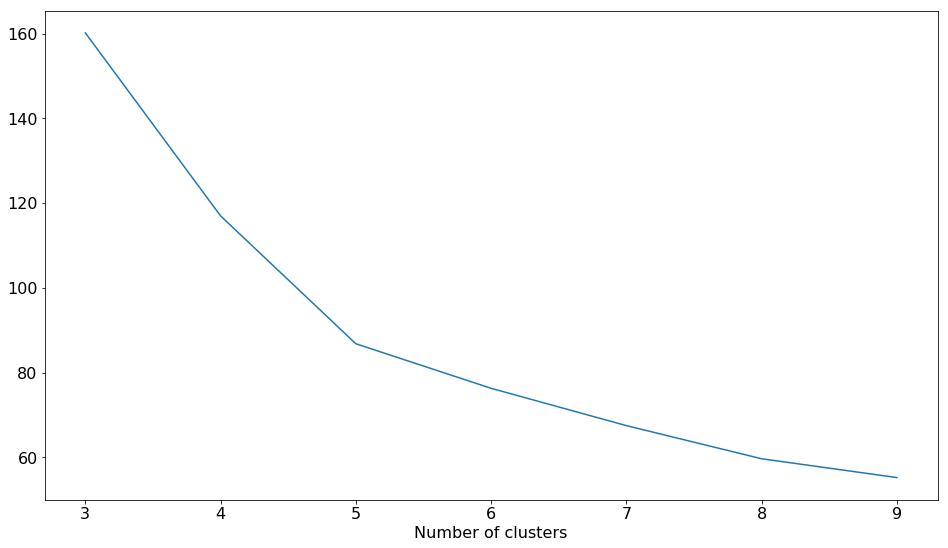

In [14]:
import matplotlib.pyplot as plt 

plt.plot(cluster_sizes, cluster_scores)
plt.xlabel('Number of clusters')
plt.show()

In [17]:
# try 7 clusters

n_clusters = 5

onlineEM.probabilities_per_kMean_cluster = np.zeros(shape=(n_clusters, onlineEM.m))
# each cluster has a number of hosts in it
onlineEM.counts_per_kMeans_cluster = np.zeros(n_clusters)
        
onlineEM.kMeans = KMeans(n_clusters, random_state=77)
onlineEM.kMeans.fit(closest_centers)

for host in onlineEM.hosts.keys():
    category = onlineEM.kMeans.predict([onlineEM.hosts[host]['group']])[0]
    onlineEM.hosts[host]['category'] = category
    points_in_cluster = onlineEM.counts_per_kMeans_cluster[category]

    onlineEM.probabilities_per_kMean_cluster[category] = \
        (onlineEM.probabilities_per_kMean_cluster[category] * points_in_cluster + onlineEM.hosts[host]['group']) / \
        (points_in_cluster + 1)

    onlineEM.counts_per_kMeans_cluster[category] += 1

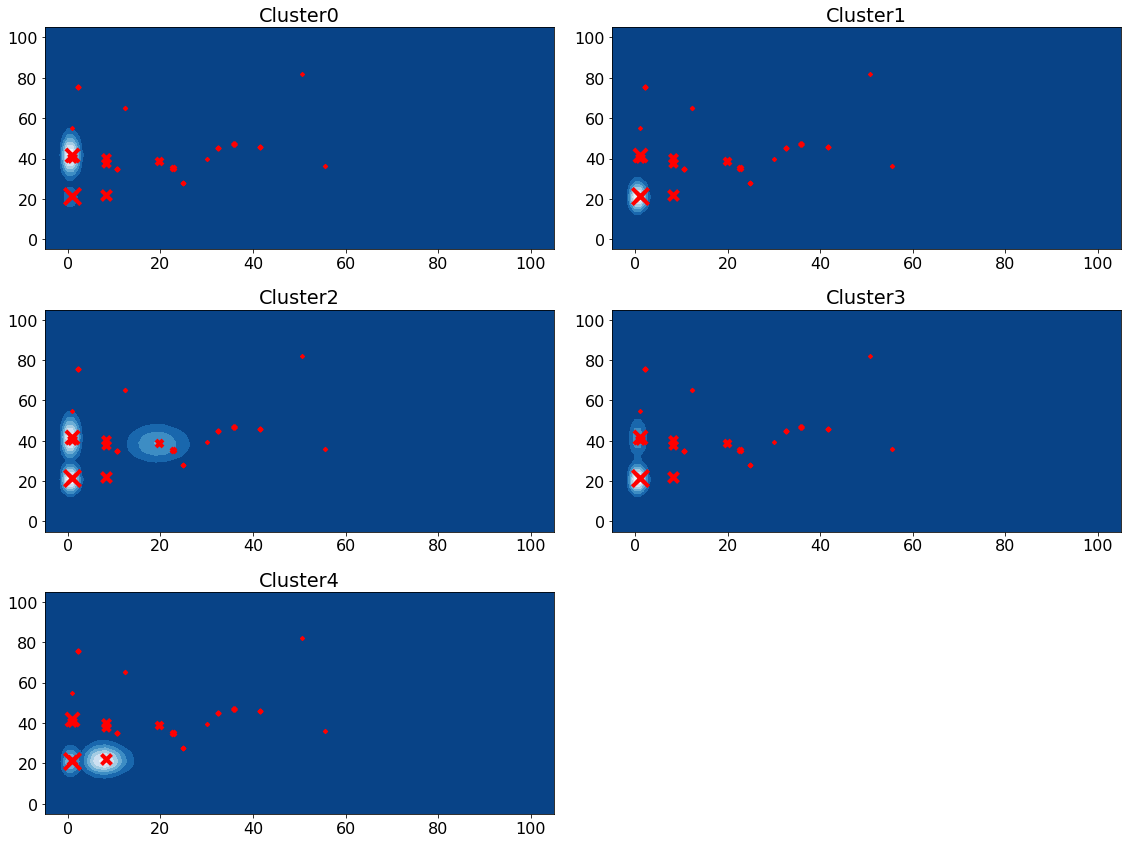

In [18]:
onlineEM.n_clusters = 5

plot_all_categories(onlineEM)

In [19]:
onlineEM.counts_per_kMeans_cluster

array([ 847.,  421.,  153.,  379.,   71.])

### How about a hierarchical approach

In [17]:
closest_centers = []

for host in onlineEM.hosts.keys():
    closest_centers.append(onlineEM.hosts[host]['group'])

<function print>

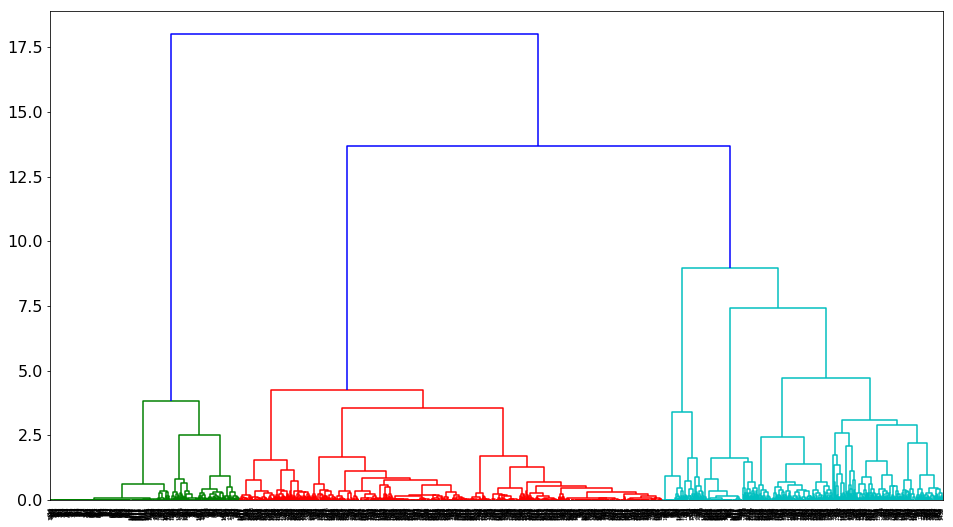

In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(closest_centers, 'ward') # εκπαιδεύει τον αλγόριθμο
dendrogram(Z) # σχεδιάζει ένα δενδρόγραμμα με το αποτέλεσμα του ιεραρχικού αλγορίθμου
print

In [29]:
Z

array([[  1.26000000e+02,   2.22000000e+02,   0.00000000e+00,
          2.00000000e+00],
       [  5.26000000e+02,   1.87100000e+03,   0.00000000e+00,
          3.00000000e+00],
       [  9.35000000e+02,   1.45900000e+03,   0.00000000e+00,
          2.00000000e+00],
       ..., 
       [  3.73200000e+03,   3.73700000e+03,   8.95059118e+00,
          5.89000000e+02],
       [  3.73500000e+03,   3.73800000e+03,   1.36931272e+01,
          1.47200000e+03],
       [  3.73400000e+03,   3.73900000e+03,   1.80136651e+01,
          1.87100000e+03]])